In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
# Set working directory
import os
os.chdir("C:\\Users\\aravi\\OneDrive\\Desktop\\VCU\\Boot camp class\\exam 2")
print(os.getcwd())

C:\Users\aravi\OneDrive\Desktop\VCU\Boot camp class\exam 2


In [4]:
# Load the data
df = pd.read_excel('CMO-Historical-Data-Monthly.xlsx', sheet_name="Monthly Prices", skiprows=6)

In [5]:
# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

In [6]:
# Convert the Date column to datetime format
def parse_date(date_str):
    # Split the string by 'M' to separate year and month
    year, month = date_str.split('M')
    # Create a date string in the format 'YYYY-MM-01'
    return f"{year}-{month}-01"

df['Date'] = pd.to_datetime(df['Date'].apply(parse_date))

# Print the data types to confirm the conversion
print(df.dtypes)

Date           datetime64[ns]
CRUDE_PETRO           float64
CRUDE_BRENT           float64
CRUDE_DUBAI           float64
CRUDE_WTI              object
                    ...      
NICKEL                float64
Zinc                  float64
GOLD                  float64
PLATINUM              float64
SILVER                float64
Length: 72, dtype: object


In [7]:
# Select specific columns (Date and selected commodities)
commodity = df.iloc[:, [0, 2, 24, 69, 71, 60, 30]]
commodity.columns = [col.lower().replace(' ', '_') for col in commodity.columns]  # Clean column names

print(commodity.dtypes)

date            datetime64[ns]
crude_brent            float64
soybeans               float64
gold                   float64
silver                 float64
urea_ee_bulk           float64
maize                  float64
dtype: object


In [8]:
# Remove the Date column for analysis
commodity_data = commodity.drop(columns=['date'])

# Column names to test
columns_to_test = commodity_data.columns

In [9]:
# Initialize counters and lists for stationary and non-stationary columns
non_stationary_count = 0
stationary_columns = []
non_stationary_columns = []

In [10]:
# Loop through each column and perform the ADF test
for col in columns_to_test:
    adf_result = adfuller(commodity_data[col])
    p_value = adf_result[1]  # Extract p-value for the test
    print(f"\nADF test result for column: {col}")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {p_value}")
    
    # Check if the p-value is greater than 0.05 (commonly used threshold)
    if p_value > 0.05:
        non_stationary_count += 1
        non_stationary_columns.append(col)
    else:
        stationary_columns.append(col)


ADF test result for column: crude_brent
ADF Statistic: -1.5078661910935385
p-value: 0.5296165197702377

ADF test result for column: soybeans
ADF Statistic: -2.423146452741887
p-value: 0.13530977427790458

ADF test result for column: gold
ADF Statistic: 1.3430517021932975
p-value: 0.9968394353612381

ADF test result for column: silver
ADF Statistic: -1.39729471074622
p-value: 0.5835723787985774

ADF test result for column: urea_ee_bulk
ADF Statistic: -2.5101716315209095
p-value: 0.11301903181624623

ADF test result for column: maize
ADF Statistic: -2.4700451060920425
p-value: 0.12293380919376751


In [11]:
# Print the number of non-stationary columns and the lists of stationary and non-stationary columns
print(f"\nNumber of non-stationary columns: {non_stationary_count}")
print(f"Non-stationary columns: {non_stationary_columns}")
print(f"Stationary columns: {stationary_columns}")


Number of non-stationary columns: 6
Non-stationary columns: ['crude_brent', 'soybeans', 'gold', 'silver', 'urea_ee_bulk', 'maize']
Stationary columns: []


In [12]:
# Co-Integration Test (Johansen's Test)
def johansen_test(df, alpha=0.05):
    out = coint_johansen(df, det_order=0, k_ar_diff=1)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1 - alpha)]]
    print(f"Trace statistic: {traces}")
    print(f"Critical values: {cvts}")
    print(f"Eigenvalues: {out.eig}")
    for col, trace, cvt in zip(df.columns, traces, cvts):
        if trace > cvt:
            print(f"{col} is cointegrated.")
        else:
            print(f"{col} is not cointegrated.")
    return out

In [13]:
# Perform Johansen cointegration test
coint_test = johansen_test(commodity_data)

Trace statistic: [261.5548149  167.67790177  98.11781369  53.4617083   21.6404865
   4.01416422]
Critical values: [95.7542 69.8189 47.8545 29.7961 15.4943  3.8415]
Eigenvalues: [0.11449947 0.08616362 0.05620349 0.04038124 0.02257335 0.0051862 ]
crude_brent is cointegrated.
soybeans is cointegrated.
gold is cointegrated.
silver is cointegrated.
urea_ee_bulk is cointegrated.
maize is cointegrated.


In [14]:
# Number of cointegrating relationships (assuming r = 1 if there's at least one significant eigenvalue)
r = sum(coint_test.lr1 > coint_test.cvt[:, 1])  # Replace with the actual number from the test results

In [15]:
df.columns

Index(['Date', 'CRUDE_PETRO', 'CRUDE_BRENT', 'CRUDE_DUBAI', 'CRUDE_WTI',
       'COAL_AUS', 'COAL_SAFRICA', 'NGAS_US', 'NGAS_EUR', 'NGAS_JP', 'iNATGAS',
       'COCOA', 'COFFEE_ARABIC', 'COFFEE_ROBUS', 'TEA_AVG', 'TEA_COLOMBO',
       'TEA_KOLKATA', 'TEA_MOMBASA', 'COCONUT_OIL', 'GRNUT', 'FISH_MEAL',
       'GRNUT_OIL', 'PALM_OIL', 'PLMKRNL_OIL', 'SOYBEANS', 'SOYBEAN_OIL',
       'SOYBEAN_MEAL', 'RAPESEED_OIL', 'SUNFLOWER_OIL', 'BARLEY', 'MAIZE',
       'SORGHUM', 'RICE_05', 'RICE_25', 'RICE_A1', 'RICE_05_VNM',
       'WHEAT_US_SRW', 'WHEAT_US_HRW', 'BANANA_EU', 'BANANA_US', 'ORANGE',
       'BEEF', 'CHICKEN', 'LAMB', 'SHRIMP_MEX', 'SUGAR_EU', 'SUGAR_US',
       'SUGAR_WLD', 'TOBAC_US', 'LOGS_CMR', 'LOGS_MYS', 'SAWNWD_CMR',
       'SAWNWD_MYS', 'PLYWOOD', 'COTTON_A_INDX', 'RUBBER_TSR20',
       'RUBBER1_MYSG', 'PHOSROCK', 'DAP', 'TSP', 'UREA_EE_BULK', 'POTASH',
       'ALUMINUM', 'IRON_ORE', 'COPPER', 'LEAD', 'Tin', 'NICKEL', 'Zinc',
       'GOLD', 'PLATINUM', 'SILVER'],
      dtype='o

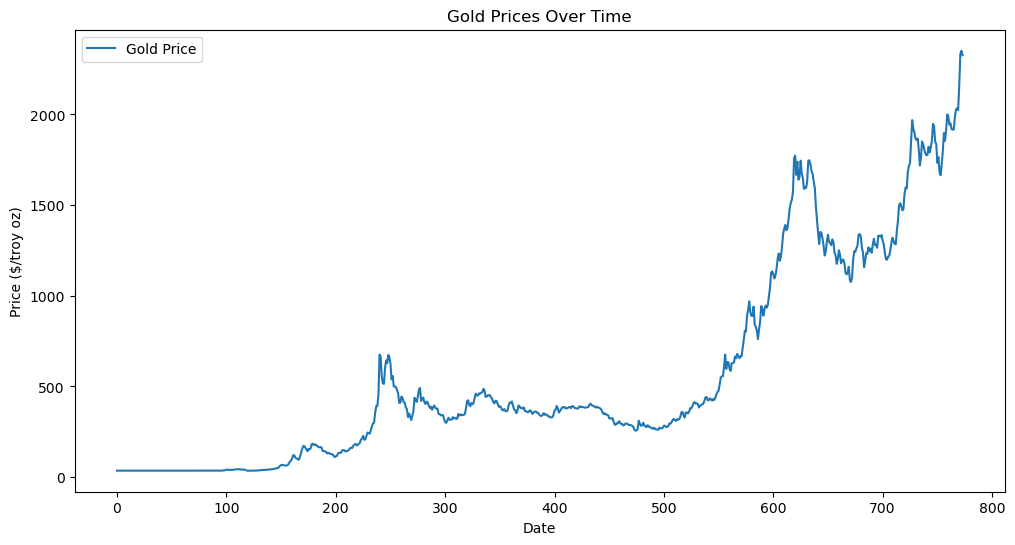

In [16]:
# Extract 'GOLD' column
gold_data = df['GOLD']

# Plot gold prices
plt.figure(figsize=(12, 6))
plt.plot(gold_data.index, gold_data, label='Gold Price')
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

In [17]:
# Split data into train and test sets
train_size = int(len(gold_data) * 0.8)
train, test = gold_data[:train_size], gold_data[train_size:]

print("Training data size:", len(train))
print("Test data size:", len(test))

Training data size: 619
Test data size: 155


In [18]:
# Fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

In [19]:
# Forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test))
sarima_forecast_index = test.index
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_forecast_conf_int = sarima_forecast.conf_int()


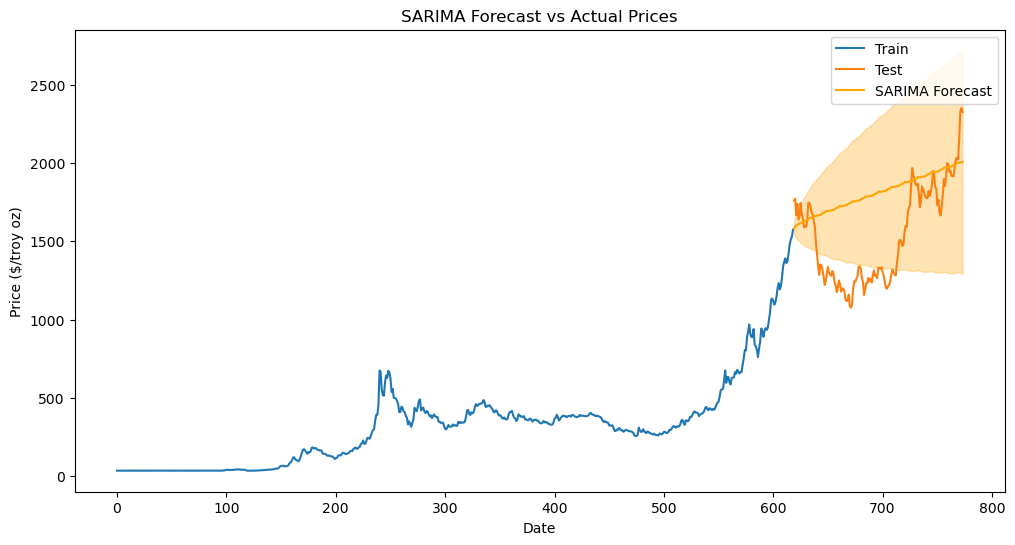

In [20]:
# Plot SARIMA Forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(sarima_forecast_index, sarima_forecast_mean, label='SARIMA Forecast', color='orange')
plt.fill_between(sarima_forecast_index, sarima_forecast_conf_int.iloc[:, 0], sarima_forecast_conf_int.iloc[:, 1], color='orange', alpha=0.3)
plt.title('SARIMA Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

In [21]:
# Evaluation metrics
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast_mean))
sarima_mape = np.mean(np.abs((test - sarima_forecast_mean) / test)) * 100
sarima_mae = mean_absolute_error(test, sarima_forecast_mean)

print(f'SARIMA RMSE: {sarima_rmse}')
print(f'SARIMA MAPE: {sarima_mape}')
print(f'SARIMA MAE: {sarima_mae}')

SARIMA RMSE: 375.30572038204065
SARIMA MAPE: 23.375858828151177
SARIMA MAE: 308.7535910989451


Interpretation: 
RMSE (Root Mean Squared Error): This measures the average magnitude of the error between the model's predictions and the actual values. A lower RMSE generally indicates better model performance. In this case, the RMSE is relatively high, suggesting that the model's predictions deviate significantly from the actual values.

MAPE (Mean Absolute Percentage Error): This calculates the average percentage error between the predicted and actual values. A lower MAPE implies better accuracy. Here, the MAPE of 23.37% indicates that, on average, the model's predictions are off by approximately 23.37%.

MAE (Mean Absolute Error): This represents the average absolute difference between the predicted and actual values. A lower MAE signifies better model performance. Similar to RMSE, the MAE is relatively high, suggesting substantial prediction errors.

Overall, based on these metrics, the SARIMA model exhibits a relatively poor performance in forecasting. The high values of RMSE, MAPE, and MAE indicate that the model's predictions are not accurate.

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
# Prepare data for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

look_back = 12
train_values = train.values
test_values = test.values

In [24]:
X_train, Y_train = create_dataset(train_values, look_back)
X_test, Y_test = create_dataset(test_values, look_back)

In [25]:
# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [26]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

C:\Users\aravi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# Train model
lstm_model.fit(X_train, Y_train, epochs=50, verbose=0)

In [28]:
# Forecast
lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = np.reshape(lstm_forecast, (lstm_forecast.shape[0]))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


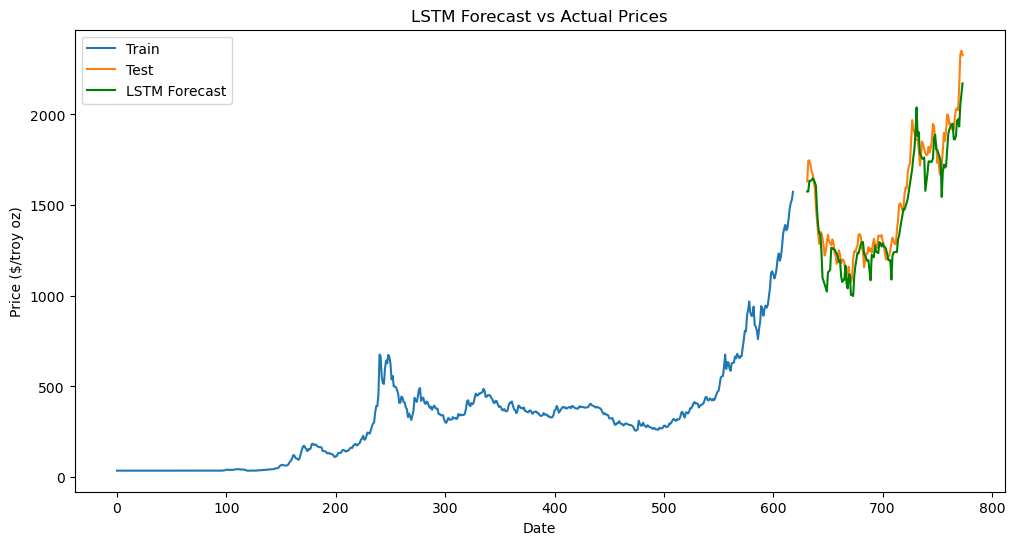

In [29]:
# Plot LSTM Forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index[look_back:], test[look_back:], label='Test')
plt.plot(test.index[look_back:], lstm_forecast, label='LSTM Forecast', color='green')
plt.title('LSTM Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

Interpretation:
The chart illustrates the performance of an LSTM model in predicting price trends compared to actual historical data. The blue line represents the training data, the green line represents the test data, and the orange line depicts the LSTM's forecasted prices. the LSTM model provides a reasonable approximation of the price trend, its accuracy in predicting short-term price movements is limited. Further refinement and experimentation are necessary to improve its predictive capabilities.

In [30]:
# Evaluation metrics
lstm_rmse = np.sqrt(mean_squared_error(test[look_back:], lstm_forecast))
lstm_mape = np.mean(np.abs((test[look_back:] - lstm_forecast) / test[look_back:])) * 100
lstm_mae = mean_absolute_error(test[look_back:], lstm_forecast)

print(f'LSTM RMSE: {lstm_rmse}')
print(f'LSTM MAPE: {lstm_mape}')
print(f'LSTM MAE: {lstm_mae}')


LSTM RMSE: 109.50841988338964
LSTM MAPE: 5.822437988027014
LSTM MAE: 88.73679034693735


Interpretation:
LSTM RMSE (Root Mean Square Error): 109.51 - This indicates the average magnitude of the error between the model's predictions and the actual values. A lower RMSE generally signifies better model performance.
LSTM MAPE (Mean Absolute Percentage Error): 5.82% - This measures the average percentage error of the model's predictions. A lower MAPE indicates better accuracy.
LSTM MAE (Mean Absolute Error): 88.74 - This represents the average absolute difference between the predicted and actual values. Lower MAE values suggest better model performance.